In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv('./data/sample.csv')

In [3]:
df

,action_taken_name,agency_name,applicant_ethnicity_name,applicant_race_name_1,applicant_sex_name,applicant_income_000s,co_applicant_ethnicity_name,co_applicant_race_name_1,co_applicant_sex_name,county_name,...,owner_occupancy_name,preapproval_name,property_type_name,purchaser_type_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population
0,Application denied by financial institution,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Female,176.0,No co-applicant,No co-applicant,No co-applicant,Chautauqua County,...,Not owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,235,2605.0,930.0,6.850000,2979.0
1,Application withdrawn by applicant,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,53.0,No co-applicant,No co-applicant,No co-applicant,Erie County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,69000.0,108,2053.0,821.0,33.580002,4416.0
2,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Male,223.0,Not Hispanic or Latino,White,Female,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,659,497.0,387.0,49.959999,1363.0
3,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,Asian,Female,43.0,No co-applicant,No co-applicant,No co-applicant,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,103,251.0,558.0,32.090000,1960.0
4,Loan originated,National Credit Union Administration,Not Hispanic or Latino,White,Male,72.0,No co-applicant,No co-applicant,No co-applicant,Steuben County,...,Owner-occupied as a principal dwelling,Preapproval was requested,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,45,1514.0,1003.0,2.120000,3391.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175857,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Female,118.0,No co-applicant,No co-applicant,No co-applicant,Nassau County,...,Owner-occupied as a principal dwelling,Preapproval was requested,One-to-four family dwelling (other than manufa...,Affiliate institution,109000.0,300,1470.0,1337.0,17.110001,4448.0
175858,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Female,27.0,No co-applicant,No co-applicant,No co-applicant,Monroe County,...,Owner-occupied as a principal dwelling,Preapproval was not requested,One-to-four family dwelling (other than manufa...,"Life insurance company, credit union, mortgage...",69700.0,88,1719.0,1490.0,16.040001,4658.0
175859,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,215.0,Not Hispanic or Latino,White,Female,Nassau County,...,Owner-occupied as a principal dwelling,Preapproval was not requested,One-to-four family dwelling (other than manufa...,Fannie Mae (FNMA),109000.0,205,1547.0,1455.0,7.730000,4671.0
175860,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,116.0,No co-applicant,No co-applicant,No co-applicant,Rockland County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Freddie Mac (FHLMC),71300.0,200,1743.0,1534.0,19.969999,5484.0


In [4]:
# Overview over null values

null_df = pd.DataFrame({'Null_Values': df.isna().sum(), 'Percentage': round((df.isna().sum())/(df.shape[0])*(100),2)}).reset_index()
null_df

,index,Null_Values,Percentage
0,action_taken_name,0,0.00
1,agency_name,0,0.00
2,applicant_ethnicity_name,0,0.00
3,applicant_race_name_1,0,0.00
4,applicant_sex_name,0,0.00
5,applicant_income_000s,24518,13.94
6,co_applicant_ethnicity_name,0,0.00
7,co_applicant_race_name_1,0,0.00
8,co_applicant_sex_name,0,0.00
9,county_name,485,0.28


In [5]:
# Creating a column with 1 for any kind of loan approval and 0 for all loan denials and file closures.

df['loan_approved'] = np.where(
   (df.action_taken_name == 'Loan originated') | (df.action_taken_name == 'Loan purchased by the institution') | (df.action_taken_name == 'Application approved but not accepted'), 1, 0)

In [6]:
# Filling null values 

df.county_name = df.county_name.fillna('No information')
df.msamd_name = df.msamd_name.fillna('No information')
df.denial_reason_name_1 = df.denial_reason_name_1.fillna(0)
df.denial_reason_name_2 = df.denial_reason_name_2.fillna(0)
df.denial_reason_name_3 = df.denial_reason_name_3.fillna(0)
df.applicant_income_000s = df.applicant_income_000s.fillna(df.applicant_income_000s.mean()).astype(int)
df.hud_median_family_income = df.hud_median_family_income.fillna(df.hud_median_family_income.mean()).astype(int)
df.minority_population = df.minority_population.fillna(df.minority_population.mean())
df.number_of_1_to_4_family_units = df.number_of_1_to_4_family_units.fillna(df.number_of_1_to_4_family_units.mean()).astype(int)
df.number_of_owner_occupied_units = df.number_of_owner_occupied_units.fillna(df.number_of_owner_occupied_units.mean()).astype(int)
df.population = df.population.fillna(df.population.mean()).astype(int)

In [7]:
# Converting columns from str to int without typing them as category

df.action_taken_name = df.action_taken_name.map({'Application denied by financial institution': 0, 'Preapproval request denied by financial institution': 1, 'File closed for incompleteness': 2, 'Application withdrawn by applicant': 3, 'Application approved but not accepted': 4, 'Loan purchased by the institution': 5, 'Loan originated': 6})

# Converting columns manually for the same order of information with applicant and co-applicant, labelling them astype('category)
df.applicant_ethnicity_name = df.applicant_ethnicity_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Not Hispanic or Latino': 1, 'Hispanic or Latino': 2, 'Not applicable': 3})
df.applicant_race_name_1 = df.applicant_race_name_1.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'White': 1, 'Asian': 2, 'Black or African American': 3, 'American Indian or Alaska Native': 4, 'Native Hawaiian or Other Pacific Islander': 5, 'Not applicable': 6})
df.applicant_sex_name = df.applicant_sex_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Female': 1, 'Male': 2, 'Not applicable': 3})
df.co_applicant_ethnicity_name = df.co_applicant_ethnicity_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Not Hispanic or Latino': 1, 'Hispanic or Latino': 2, 'Not applicable': 3, 'No co-applicant': 4})
df.co_applicant_race_name_1 = df.co_applicant_race_name_1.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'White': 1, 'Asian': 2, 'Black or African American': 3, 'American Indian or Alaska Native': 4, 'Native Hawaiian or Other Pacific Islander': 5, 'Not applicable': 6, 'No co-applicant': 7})
df.co_applicant_sex_name = df.co_applicant_sex_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Female': 1, 'Male': 2, 'Not applicable': 3, 'No co-applicant': 4})
df.denial_reason_name_1 = df.denial_reason_name_1.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})
df.denial_reason_name_2 = df.denial_reason_name_2.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})
df.denial_reason_name_3 = df.denial_reason_name_3.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})


In [8]:
# Converting several columns from str to int, labelling some of them astype('category)

column_list = [1, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21]

for i in column_list:
    df.iloc[:,i] = pd.Categorical(df.iloc[:,i], ordered=True).codes
    # df.iloc[:,i] = df.iloc[:,i].astype('category')

In [9]:
df.dtypes

action_taken_name                   int64
agency_name                          int8
applicant_ethnicity_name            int64
applicant_race_name_1               int64
applicant_sex_name                  int64
applicant_income_000s               int32
co_applicant_ethnicity_name         int64
co_applicant_race_name_1            int64
co_applicant_sex_name               int64
county_name                          int8
denial_reason_name_1                int64
denial_reason_name_2                int64
denial_reason_name_3                int64
hoepa_status_name                    int8
lien_status_name                     int8
loan_purpose_name                    int8
loan_type_name                       int8
msamd_name                           int8
owner_occupancy_name                 int8
preapproval_name                     int8
property_type_name                   int8
purchaser_type_name                  int8
hud_median_family_income            int32
loan_amount_000s                  

<AxesSubplot:>

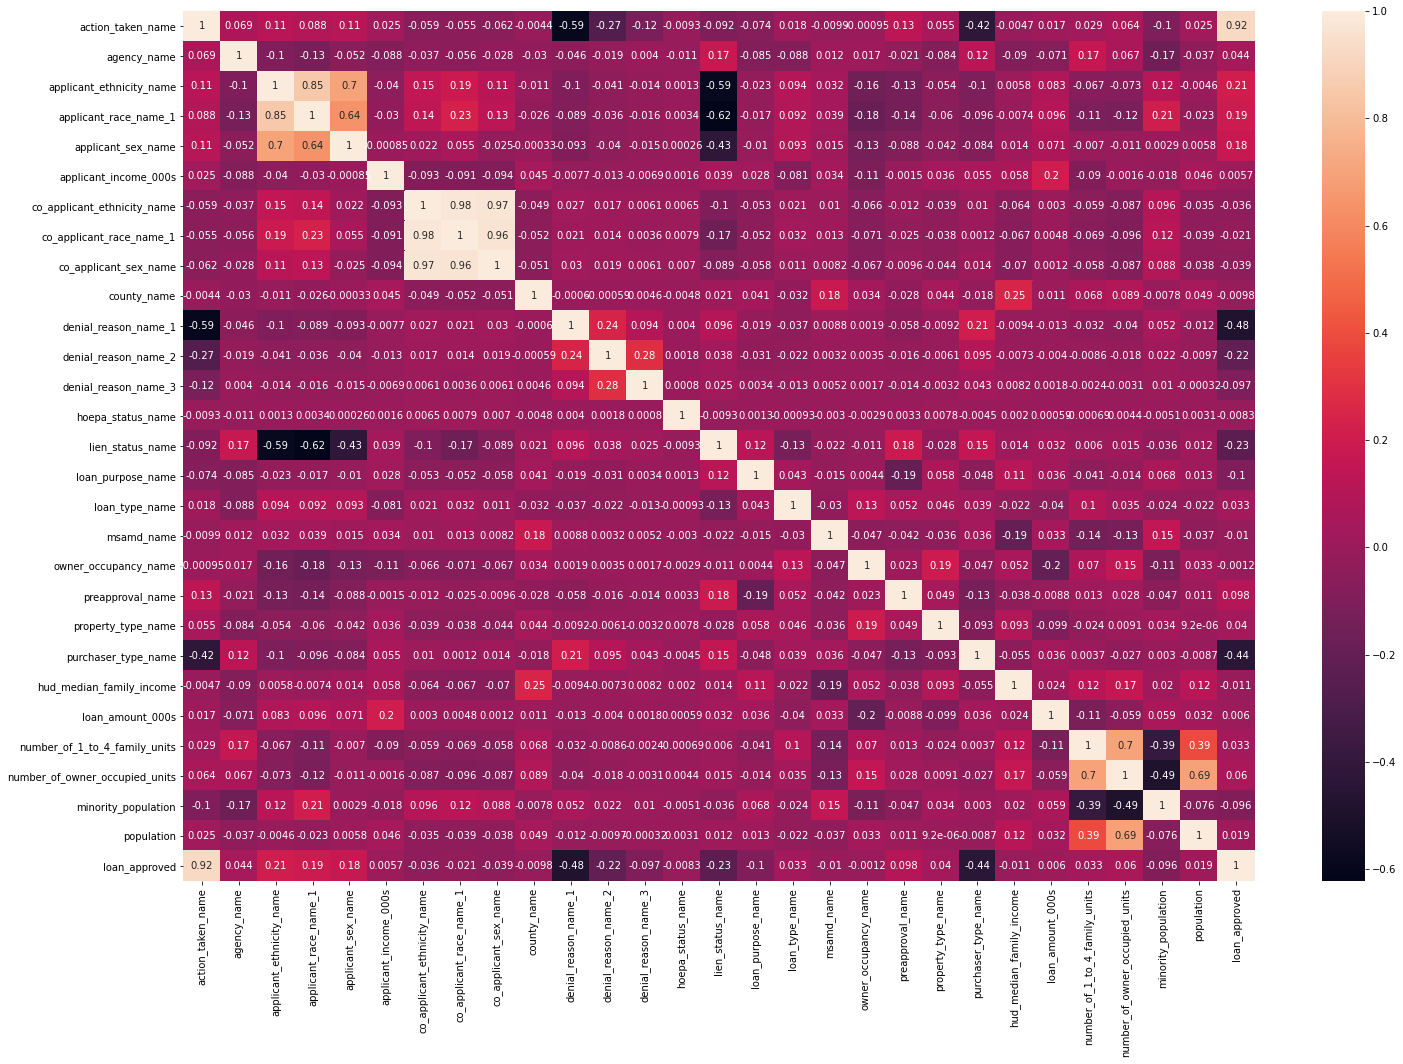

In [10]:
fig, ax = plt.subplots(figsize=(24, 16)) 
sns.heatmap(df.corr(), annot=True, ax = ax)

In [11]:
df.var()

action_taken_name                 5.284196e+00
agency_name                       2.723266e+00
applicant_ethnicity_name          5.795075e-01
applicant_race_name_1             2.909737e+00
applicant_sex_name                5.531195e-01
applicant_income_000s             6.419958e+04
co_applicant_ethnicity_name       2.143205e+00
co_applicant_race_name_1          8.174348e+00
co_applicant_sex_name             1.895169e+00
county_name                       2.541271e+02
denial_reason_name_1              1.814050e+00
denial_reason_name_2              4.989755e-01
denial_reason_name_3              1.107187e-01
hoepa_status_name                 1.535068e-04
lien_status_name                  5.560367e-01
loan_purpose_name                 4.161178e-01
loan_type_name                    4.669386e-01
msamd_name                        1.121180e+01
owner_occupancy_name              1.346662e-01
preapproval_name                  2.045529e-01
property_type_name                7.736994e-02
purchaser_typ

In [12]:
# Correlation depending on is_canceled

df.corr()['loan_approved'].abs().sort_values(ascending = False)

loan_approved                     1.000000
action_taken_name                 0.922814
denial_reason_name_1              0.476384
purchaser_type_name               0.440799
lien_status_name                  0.233601
denial_reason_name_2              0.215549
applicant_ethnicity_name          0.208771
applicant_race_name_1             0.189559
applicant_sex_name                0.176196
loan_purpose_name                 0.100206
preapproval_name                  0.097969
denial_reason_name_3              0.096835
minority_population               0.095530
number_of_owner_occupied_units    0.059527
agency_name                       0.044437
property_type_name                0.039909
co_applicant_sex_name             0.039350
co_applicant_ethnicity_name       0.035548
loan_type_name                    0.033110
number_of_1_to_4_family_units     0.032878
co_applicant_race_name_1          0.021127
population                        0.019150
hud_median_family_income          0.011151
msamd_name 

In [13]:
X = df.drop(['action_taken_name', 'loan_approved'], axis = 1)
y = df['loan_approved']
y = np.array(y)

In [14]:
# How many denied (0) or approved (1) loans does the dataset contain?

print('Distribution: loan is approved (1) or denied (0): \n' + str(pd.Series(y).value_counts()))
print('In Percent: \n' + str(pd.Series(y).value_counts() / pd.Series(y).count() * 100))

Distribution: loan is approved (1) or denied (0): 
1    121407
0     54455
dtype: int64
In Percent: 
1    69.03538
0    30.96462
dtype: float64


In [15]:
# The dataset is obviously very imbalanced. 
# A prediction with a high accuracy and Kappa is therefor only possible with a lot of try and error in feature optimization. 
# A possible solution: Oversampling!

In [16]:
# Oversampling: Balances the imbalanced dataset out by creating more samples with "canceled data" for better prediction results. 

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [17]:
# Scaling 

# X_scaled = StandardScaler().fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_resampled)

# Training

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 3)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size = 0.25, random_state = 3)

In [18]:
# # After Oversampling

print('Distribution after Oversampling: \n' + str(pd.Series(y_resampled).value_counts()))

Distribution after Oversampling: 
1    121407
0    121407
dtype: int64


In [19]:
# Logistic Regression
model_lr = LogisticRegression().fit(X_train, y_train)
model_lr_prediction = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, model_lr_prediction)

conf_lr = confusion_matrix(y_test, model_lr_prediction)
clf_report_lr = classification_report(y_test, model_lr_prediction)

print(f"Accuracy Score of Logistic Regression is : {accuracy_lr}")
print(f"Confusion Matrix : \n{conf_lr}")
print(f"Classification Report : \n{clf_report_lr}")

Accuracy Score of Logistic Regression is : 0.832844623089088
Confusion Matrix : 
[[26386  4066]
 [ 6081 24171]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     30452
           1       0.86      0.80      0.83     30252

    accuracy                           0.83     60704
   macro avg       0.83      0.83      0.83     60704
weighted avg       0.83      0.83      0.83     60704



In [20]:
kappa_lr = cohen_kappa_score(y_test, model_lr_prediction)
kappa_lr

0.6656124771914105

In [21]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=1500).fit(X_train, y_train)
model_rf_prediction = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, model_rf_prediction)

conf_rf = confusion_matrix(y_test, model_rf_prediction)
clf_report_rf = classification_report(y_test, model_rf_prediction)

print(f"Accuracy Score of Random Forest is : {accuracy_rf}")
print(f"Confusion Matrix : \n{conf_rf}")
print(f"Classification Report : \n{clf_report_rf}")

Accuracy Score of Random Forest is : 0.9386696099103848
Confusion Matrix : 
[[29451  1001]
 [ 2722 27530]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     30452
           1       0.96      0.91      0.94     30252

    accuracy                           0.94     60704
   macro avg       0.94      0.94      0.94     60704
weighted avg       0.94      0.94      0.94     60704



In [22]:
kappa_rf = cohen_kappa_score(y_test, model_rf_prediction)
kappa_rf

0.8773149689746552

In [23]:
# Decision Tree
model_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
model_dt_prediction = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, model_dt_prediction)

conf_dt = confusion_matrix(y_test, model_dt_prediction)
clf_report_dt = classification_report(y_test, model_dt_prediction)

print(f"Accuracy Score of Decision Tree is : {accuracy_dt}")
print(f"Confusion Matrix : \n{conf_dt}")
print(f"Classification Report : \n{clf_report_dt}")

Accuracy Score of Decision Tree is : 0.92254217185029
Confusion Matrix : 
[[29006  1446]
 [ 3256 26996]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     30452
           1       0.95      0.89      0.92     30252

    accuracy                           0.92     60704
   macro avg       0.92      0.92      0.92     60704
weighted avg       0.92      0.92      0.92     60704



In [24]:
kappa_dt = cohen_kappa_score(y_test, model_dt_prediction)
kappa_dt

0.8450522186291267

Maximum:  0.9197952218430034
Mean:  0.8814241636674787


<AxesSubplot:>

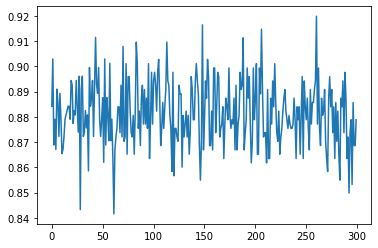

In [25]:
# K-Fold DecisionTree
model_kfdt = cross_val_score(tree.DecisionTreeClassifier(max_depth = 7), X, y, cv=300)
print('Maximum: ', model_kfdt.max())
print('Mean: ', model_kfdt.mean())

model_kfdt = pd.Series(model_kfdt)
model_kfdt.plot()

In [26]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2).fit(X_train, y_train)
model_knn_prediction = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, model_knn_prediction)

conf_knn = confusion_matrix(y_test, model_knn_prediction)
clf_report_knn = classification_report(y_test, model_knn_prediction)

print(f"Accuracy Score of KNN is : {accuracy_knn}")
print(f"Confusion Matrix : \n{conf_knn}")
print(f"Classification Report : \n{clf_report_knn}")

Accuracy Score of Ada Boost Classifier is : 0.8488402741170269
Confusion Matrix : 
[[26961  3491]
 [ 5685 24567]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.89      0.85     30452
           1       0.88      0.81      0.84     30252

    accuracy                           0.85     60704
   macro avg       0.85      0.85      0.85     60704
weighted avg       0.85      0.85      0.85     60704



In [27]:
kappa_knn = cohen_kappa_score(y_test, model_knn_prediction)
kappa_knn

0.697605248570548

In [28]:
# Ada Boost
model_ada = AdaBoostClassifier(n_estimators = 1000).fit(X_train, y_train)
model_ada_prediction = model_ada.predict(X_test)
accuracy_ada = accuracy_score(y_test, model_ada_prediction)

conf_ada = confusion_matrix(y_test, model_ada_prediction)
clf_report_ada = classification_report(y_test, model_ada_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_ada}")
print(f"Confusion Matrix : \n{conf_ada}")
print(f"Classification Report : \n{clf_report_ada}")

Accuracy Score of Ada Boost Classifier is : 0.8812928307854507
Confusion Matrix : 
[[27373  3079]
 [ 4127 26125]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.90      0.88     30452
           1       0.89      0.86      0.88     30252

    accuracy                           0.88     60704
   macro avg       0.88      0.88      0.88     60704
weighted avg       0.88      0.88      0.88     60704



In [29]:
kappa_ada = cohen_kappa_score(y_test, model_ada_prediction)
kappa_ada

0.7625560727044404

In [30]:
# Gradient Boosting Classifier
model_gb = GradientBoostingClassifier().fit(X_train, y_train)
model_gb_prediction = model_gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, model_gb_prediction)
conf_gb = confusion_matrix(y_test, model_gb_prediction)
clf_report_gb = classification_report(y_test, model_gb_prediction)

print(f"Accuracy Score of Gradient Boosting Classifier is : {accuracy_gb}")
print(f"Confusion Matrix : \n{conf_gb}")
print(f"Classification Report : \n{clf_report_gb}")

Accuracy Score of Ada Boost Classifier is : 0.8833025830258303
Confusion Matrix : 
[[27625  2827]
 [ 4257 25995]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     30452
           1       0.90      0.86      0.88     30252

    accuracy                           0.88     60704
   macro avg       0.88      0.88      0.88     60704
weighted avg       0.88      0.88      0.88     60704



In [31]:
kappa_gb = cohen_kappa_score(y_test, model_gb_prediction)
kappa_gb

0.7665663974464783

In [32]:
# XgBoost Classifier
model_xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180).fit(X_train, y_train)
model_xgb_prediction = model_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, model_xgb_prediction)
conf_xgb = confusion_matrix(y_test, model_xgb_prediction)
clf_report_xgb = classification_report(y_test, model_xgb_prediction)

print(f"Accuracy Score of XgBoost Classifier is : {accuracy_xgb}")
print(f"Confusion Matrix : \n{conf_xgb}")
print(f"Classification Report : \n{clf_report_xgb}")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:29:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score of XgBoost Classifier is : 0.8903861360042172
Confusion Matrix : 
[[27505  2947]
 [ 3707 26545]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     30452
           1       0.90      0.88      0.89     30252

    accuracy                           0.89     60704
   macro avg       0.89      0.89      0.89     60704
weighted avg       0.89      0.89      0.89     60704



In [33]:
kappa_xgb = cohen_kappa_score(y_test, model_xgb_prediction)
kappa_xgb

0.7807518047416113

In [34]:
# Cat Boost Classifier
model_cat = CatBoostClassifier(iterations=100).fit(X_train, y_train)
model_cat_prediction = model_cat.predict(X_test)

accuracy_cat = accuracy_score(y_test, model_cat_prediction)
conf_cat = confusion_matrix(y_test, model_cat_prediction)
clf_report_cat = classification_report(y_test, model_cat_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_cat}")
print(f"Confusion Matrix : \n{conf_cat}")
print(f"Classification Report : \n{clf_report_cat}")

Learning rate set to 0.5
0:	learn: 0.2872812	total: 205ms	remaining: 20.3s
1:	learn: 0.2587912	total: 270ms	remaining: 13.2s
2:	learn: 0.2516155	total: 344ms	remaining: 11.1s
3:	learn: 0.2464221	total: 398ms	remaining: 9.56s
4:	learn: 0.2432443	total: 451ms	remaining: 8.57s
5:	learn: 0.2407738	total: 505ms	remaining: 7.91s
6:	learn: 0.2391829	total: 565ms	remaining: 7.51s
7:	learn: 0.2370391	total: 630ms	remaining: 7.25s
8:	learn: 0.2361686	total: 699ms	remaining: 7.07s
9:	learn: 0.2345805	total: 759ms	remaining: 6.83s
10:	learn: 0.2335550	total: 842ms	remaining: 6.81s
11:	learn: 0.2330750	total: 914ms	remaining: 6.71s
12:	learn: 0.2324505	total: 978ms	remaining: 6.54s
13:	learn: 0.2318842	total: 1.04s	remaining: 6.38s
14:	learn: 0.2314856	total: 1.1s	remaining: 6.26s
15:	learn: 0.2307156	total: 1.21s	remaining: 6.33s
16:	learn: 0.2300258	total: 1.3s	remaining: 6.36s
17:	learn: 0.2294792	total: 1.39s	remaining: 6.32s
18:	learn: 0.2290167	total: 1.48s	remaining: 6.31s
19:	learn: 0.22878

In [35]:
kappa_cat = cohen_kappa_score(y_test, model_cat_prediction)
kappa_cat

0.7913259150721627

In [36]:
# Extra Trees Classifier
model_etc = ExtraTreesClassifier().fit(X_train, y_train)
model_etc_prediction = model_etc.predict(X_test)

accuracy_etc = accuracy_score(y_test, model_etc_prediction)
conf_etc = confusion_matrix(y_test, model_etc_prediction)
clf_report_etc = classification_report(y_test, model_etc_prediction)

print(f"Accuracy Score of Extra Trees Classifier is : {accuracy_etc}")
print(f"Confusion Matrix : \n{conf_etc}")
print(f"Classification Report : \n{clf_report_etc}")

Accuracy Score of Cat Boost Classifier is : 0.9396909594095941
Confusion Matrix : 
[[29251  1201]
 [ 2460 27792]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     30452
           1       0.96      0.92      0.94     30252

    accuracy                           0.94     60704
   macro avg       0.94      0.94      0.94     60704
weighted avg       0.94      0.94      0.94     60704



In [37]:
kappa_etc = cohen_kappa_score(y_test, model_etc_prediction)
kappa_etc

0.87936412286349

In [38]:
# LGBM Classifier
model_lgbm = LGBMClassifier(learning_rate = 1).fit(X_train, y_train)
model_lgbm_prediction = model_lgbm.predict(X_test)

accuracy_lgbm = accuracy_score(y_test, model_lgbm_prediction)
conf_lgbm = confusion_matrix(y_test, model_lgbm_prediction)
clf_report_lgbm = classification_report(y_test, model_lgbm_prediction)

print(f"Accuracy Score of LGBM Classifier is : {accuracy_lgbm}")
print(f"Confusion Matrix : \n{conf_lgbm}")
print(f"Classification Report : \n{clf_report_lgbm}")

Accuracy Score of Cat Boost Classifier is : 0.895179889298893
Confusion Matrix : 
[[27726  2726]
 [ 3637 26615]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     30452
           1       0.91      0.88      0.89     30252

    accuracy                           0.90     60704
   macro avg       0.90      0.90      0.90     60704
weighted avg       0.90      0.90      0.90     60704



In [39]:
kappa_lgbm = cohen_kappa_score(y_test, model_lgbm_prediction)
kappa_lgbm

0.7903367695417616

In [40]:
# Voting Classifier
classifiers = [('Gradient Boosting Classifier', model_gb), ('Cat Boost Classifier', model_cat), ('XGboost', model_xgb),  
               ('Decision Tree', model_dt), ('Extra Tree', model_etc), ('Light Gradient', model_lgbm), ('Random Forest', model_rf), 
               ('Ada Boost', model_ada), ('Logistic', model_lr), ('Knn', model_knn)]
model_vc = VotingClassifier(estimators = classifiers).fit(X_train, y_train)
model_vc_prediction = model_vc.predict(X_test)

accuracy_vc = accuracy_score(y_test, model_vc_prediction)
conf_vc = confusion_matrix(y_test, model_vc_prediction)
clf_report_vc = classification_report(y_test, model_vc_prediction)

print(f"Accuracy Score of Voting Classifier is : {accuracy_vc}")
print(f"Confusion Matrix : \n{conf_vc}")
print(f"Classification Report : \n{clf_report_vc}")

Learning rate set to 0.5
0:	learn: 0.2872812	total: 54.7ms	remaining: 5.42s
1:	learn: 0.2587912	total: 102ms	remaining: 5.01s
2:	learn: 0.2516155	total: 145ms	remaining: 4.7s
3:	learn: 0.2464221	total: 191ms	remaining: 4.59s
4:	learn: 0.2432443	total: 239ms	remaining: 4.53s
5:	learn: 0.2407738	total: 283ms	remaining: 4.44s
6:	learn: 0.2391829	total: 341ms	remaining: 4.53s
7:	learn: 0.2370391	total: 388ms	remaining: 4.46s
8:	learn: 0.2361686	total: 435ms	remaining: 4.4s
9:	learn: 0.2345805	total: 479ms	remaining: 4.31s
10:	learn: 0.2335550	total: 523ms	remaining: 4.23s
11:	learn: 0.2330750	total: 573ms	remaining: 4.2s
12:	learn: 0.2324505	total: 625ms	remaining: 4.18s
13:	learn: 0.2318842	total: 669ms	remaining: 4.11s
14:	learn: 0.2314856	total: 712ms	remaining: 4.03s
15:	learn: 0.2307156	total: 759ms	remaining: 3.98s
16:	learn: 0.2300258	total: 805ms	remaining: 3.93s
17:	learn: 0.2294792	total: 854ms	remaining: 3.89s
18:	learn: 0.2290167	total: 903ms	remaining: 3.85s
19:	learn: 0.22878

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score of Voting Classifier is : 0.915359778597786
Confusion Matrix : 
[[28955  1497]
 [ 3641 26611]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     30452
           1       0.95      0.88      0.91     30252

    accuracy                           0.92     60704
   macro avg       0.92      0.92      0.92     60704
weighted avg       0.92      0.92      0.92     60704



In [41]:
kappa_vc = cohen_kappa_score(y_test, model_vc_prediction)
kappa_vc

0.8306783131923773

In [42]:
# Models Comparison
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Cat Boost', 'Extra Trees Classifier', 'LGBM', 'Voting Classifier', 'K-Fold Decision Tree'],
    'Score' : [accuracy_lr, accuracy_knn, accuracy_dt, accuracy_rf, accuracy_ada, accuracy_gb, accuracy_xgb, accuracy_cat, 
              accuracy_etc, accuracy_lgbm, accuracy_vc, model_kfdt.mean()],
    'Kappa' : [kappa_lr, kappa_knn, kappa_dt, kappa_rf, kappa_ada, kappa_gb, kappa_xgb, kappa_cat, kappa_etc, kappa_lgbm, 
              kappa_vc, model_kfdt.mean()]
})


models.sort_values(by = 'Kappa', ascending = False)

,Model,Score,Kappa
11,K-Fold Decision Tree,0.881424,0.881424
8,Extra Trees Classifier,0.939691,0.879364
3,Random Forest Classifier,0.938670,0.877315
2,Decision Tree Classifier,0.922542,0.845052
10,Voting Classifier,0.915360,0.830678
7,Cat Boost,0.895674,0.791326
9,LGBM,0.895180,0.790337
6,XgBoost,0.890386,0.780752
5,Gradient Boosting Classifier,0.883303,0.766566
4,Ada Boost Classifier,0.881293,0.762556
